In [1]:
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Emitter, Transitioner, Initializers, Training
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
from learnMSA.protein_language_models import Common, EmbeddingBatchGenerator

2024-10-21 15:50:50.322557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 15:50:50.331266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 15:50:50.333867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1729525851.361302  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525851.379301  157111 cuda_executor.cc:1015] succ


# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 4

HMM training supported by protein embeddings:

In [3]:
def align(filename, out_filename):
    scoring_model_config = Common.ScoringModelConfig(dim=32, lm_name="protT5", activation="softmax", scaled=False)
    config = Configuration.make_default(num_models, 
                                        use_language_model=True, 
                                        scoring_model_config=scoring_model_config,
                                        frozen_insertions=True,
                                        num_prior_components=10,
                                        V2_emitter=True,
                                        V2_temperature=3.)
    #config["batch_size"] = 16
    # we have to define a special model- and batch generator if using a language model
    # because the emission probabilities are computed differently and the LM requires specific inputs
    model_gen = EmbeddingBatchGenerator.make_generic_embedding_model_generator(config["scoring_model_config"].dim)
    batch_gen = EmbeddingBatchGenerator.EmbeddingBatchGenerator(config["scoring_model_config"])
    with SequenceDataset(train_filename, fmt="fasta") as data:
        config["crop_long_seqs"] = int(np.ceil(3 * np.mean(data.seq_lens)))
        alignment_model = Align.run_learnMSA(data,
                                            out_filename,
                                            config, 
                                            model_generator=model_gen,
                                            batch_generator=batch_gen,
                                            sequence_weights=Align.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
                                            verbose=True,
                                            align_insertions=True)
    return alignment_model

Training of 4 models on file egf.fasta
Configuration: 
{
num_models : 4
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=10000

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing all embeddings (this may take a while).
10% done.
20% done.
30% done.
40% done.
50% done.
60% done.
70% done.
80% done.
90% done.
100% done.
Fitting models of lengths [26 24 25 25] on 7774 sequences.
Batch size= 100 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1729525910.721393  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525910.721593  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525910.721719  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525910.721872  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices', 'embeddings']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1729525912.886039  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525912.886237  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525912.886362  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negati

88/88 - 20s - 230ms/step - loss: 73.4204 - loglik: -6.9020e+01 - prior: -3.5381e+00 - aux_loss: 0.8628
Epoch 2/10
88/88 - 5s - 51ms/step - loss: 73.2275 - loglik: -7.0266e+01 - prior: -2.0863e+00 - aux_loss: 0.8756
Epoch 3/10
88/88 - 5s - 52ms/step - loss: 72.3426 - loglik: -6.9749e+01 - prior: -1.7306e+00 - aux_loss: 0.8625
Epoch 4/10
88/88 - 4s - 49ms/step - loss: 72.1450 - loglik: -6.9612e+01 - prior: -1.6525e+00 - aux_loss: 0.8803
Epoch 5/10
88/88 - 4s - 51ms/step - loss: 70.5940 - loglik: -6.8172e+01 - prior: -1.5435e+00 - aux_loss: 0.8789
Epoch 6/10
88/88 - 5s - 52ms/step - loss: 71.0927 - loglik: -6.8747e+01 - prior: -1.4789e+00 - aux_loss: 0.8673


I0000 00:00:1729525957.067937  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525957.068161  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525957.068317  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525957.068511  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(6, 1), (11, 2), (13, 2), (16, 1), (17, 1)]
discards model 0: []
expansions model 1: [(12, 4), (13, 2), (14, 1), (15, 1)]
discards model 1: []
expansions model 2: [(6, 1), (11, 2), (12, 3), (13, 1), (16, 1)]
discards model 2: []
expansions model 3: [(0, 1), (10, 1), (11, 2), (12, 3), (15, 1), (16, 1)]
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [33, 32, 33, 34] on 7774 sequences.
Batch size= 100 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1729525962.445172  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525962.445404  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525962.445564  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525962.445755  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/4


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices', 'embeddings']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1729525964.398891  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525964.399094  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525964.399222  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negati

88/88 - 19s - 218ms/step - loss: 71.2164 - loglik: -6.7291e+01 - prior: -3.0665e+00 - aux_loss: 0.8593
Epoch 2/4
88/88 - 4s - 50ms/step - loss: 67.3283 - loglik: -6.5190e+01 - prior: -1.2800e+00 - aux_loss: 0.8579
Epoch 3/4
88/88 - 4s - 51ms/step - loss: 66.2102 - loglik: -6.4605e+01 - prior: -7.3098e-01 - aux_loss: 0.8740
Epoch 4/4
88/88 - 4s - 51ms/step - loss: 65.9941 - loglik: -6.4628e+01 - prior: -4.9211e-01 - aux_loss: 0.8740


I0000 00:00:1729525997.795471  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525997.795701  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525997.795860  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729525997.796048  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: []
discards model 0: [12 16]
expansions model 1: []
discards model 1: [17]
expansions model 2: [(0, 1)]
discards model 2: [12 15]
expansions model 3: []
discards model 3: [ 1 13 16]
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 32, 31] on 7774 sequences.
Batch size= 100 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1729526003.077709  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526003.077951  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526003.078126  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526003.078320  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/4


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices', 'embeddings']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1729526005.028208  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526005.028443  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526005.028604  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negati

88/88 - 19s - 213ms/step - loss: 68.2610 - loglik: -6.4932e+01 - prior: -2.4337e+00 - aux_loss: 0.8950
Epoch 2/4
88/88 - 5s - 52ms/step - loss: 66.1902 - loglik: -6.4734e+01 - prior: -5.6121e-01 - aux_loss: 0.8951
Epoch 3/4
88/88 - 5s - 52ms/step - loss: 64.8954 - loglik: -6.3899e+01 - prior: -1.0702e-01 - aux_loss: 0.8891
Epoch 4/4
88/88 - 5s - 51ms/step - loss: 64.5446 - loglik: -6.3769e+01 - prior: 0.0944 - aux_loss: 0.8697


I0000 00:00:1729526038.379115  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526038.379344  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526038.379503  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526038.379694  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: []
discards model 0: []
expansions model 1: []
discards model 1: []
expansions model 2: []
discards model 2: [1]
expansions model 3: [(0, 1)]
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 31, 32] on 7774 sequences.
Batch size= 100 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1729526044.001343  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526044.001567  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526044.001725  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526044.001919  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/20


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices', 'embeddings']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1729526045.889775  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526045.889972  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526045.890103  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negati

88/88 - 18s - 210ms/step - loss: 64.8932 - loglik: -6.2303e+01 - prior: -1.7131e+00 - aux_loss: 0.8774
Epoch 2/20
88/88 - 5s - 51ms/step - loss: 67.6605 - loglik: -6.6586e+01 - prior: -1.8379e-01 - aux_loss: 0.8909
Time for alignment: 213.3912
Likelihoods:  ['-59.7788', '-59.9797', '-59.8862', '-60.0297']
Mean likelihood:  -59.9185879420032
Selection criterion: AIC
Best model:  0 (0-based)


I0000 00:00:1729526085.708171  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526085.708359  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526085.708482  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526085.708638  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Aligning 2 insertion slices with famsa.


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


time for generating output: 3.3541
Wrote file test/data/interactive.alignment.fasta
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step
>l=-53.96_t=0.03
.....................$CD......P............NP........CYN.HG..T..CS........L......................R..AT.....G..........YTCSCL..PR......YT....GEH$..........................
>l=-56.46_t=0.03
.....................$CD......S............QP........CRN.-G..T..CSl.......N......................T..NT.....D..........YTCACF..PG......YT....GRY$..........................
>l=-49.27_t=0.03
.....................$CD......S............DP........CLN.GG..T..CT........L......................Rs.LD.....S..........YSCACA..PG......YT....GQH$..........................
>l=-64.53_t=0.03
.....................$CD......H............VT........CLN.GG..T..CQ........L......................Kt.LE.....D..........YTCACA..NG......YT....GER$..........................
>l=-64.95_t=0.03
.....................$CD......H............VT........CLN.GG..T..CQ........L......................Kt.LE.....

I0000 00:00:1729526097.769478  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526097.769647  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526097.769776  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729526097.769922  157111 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

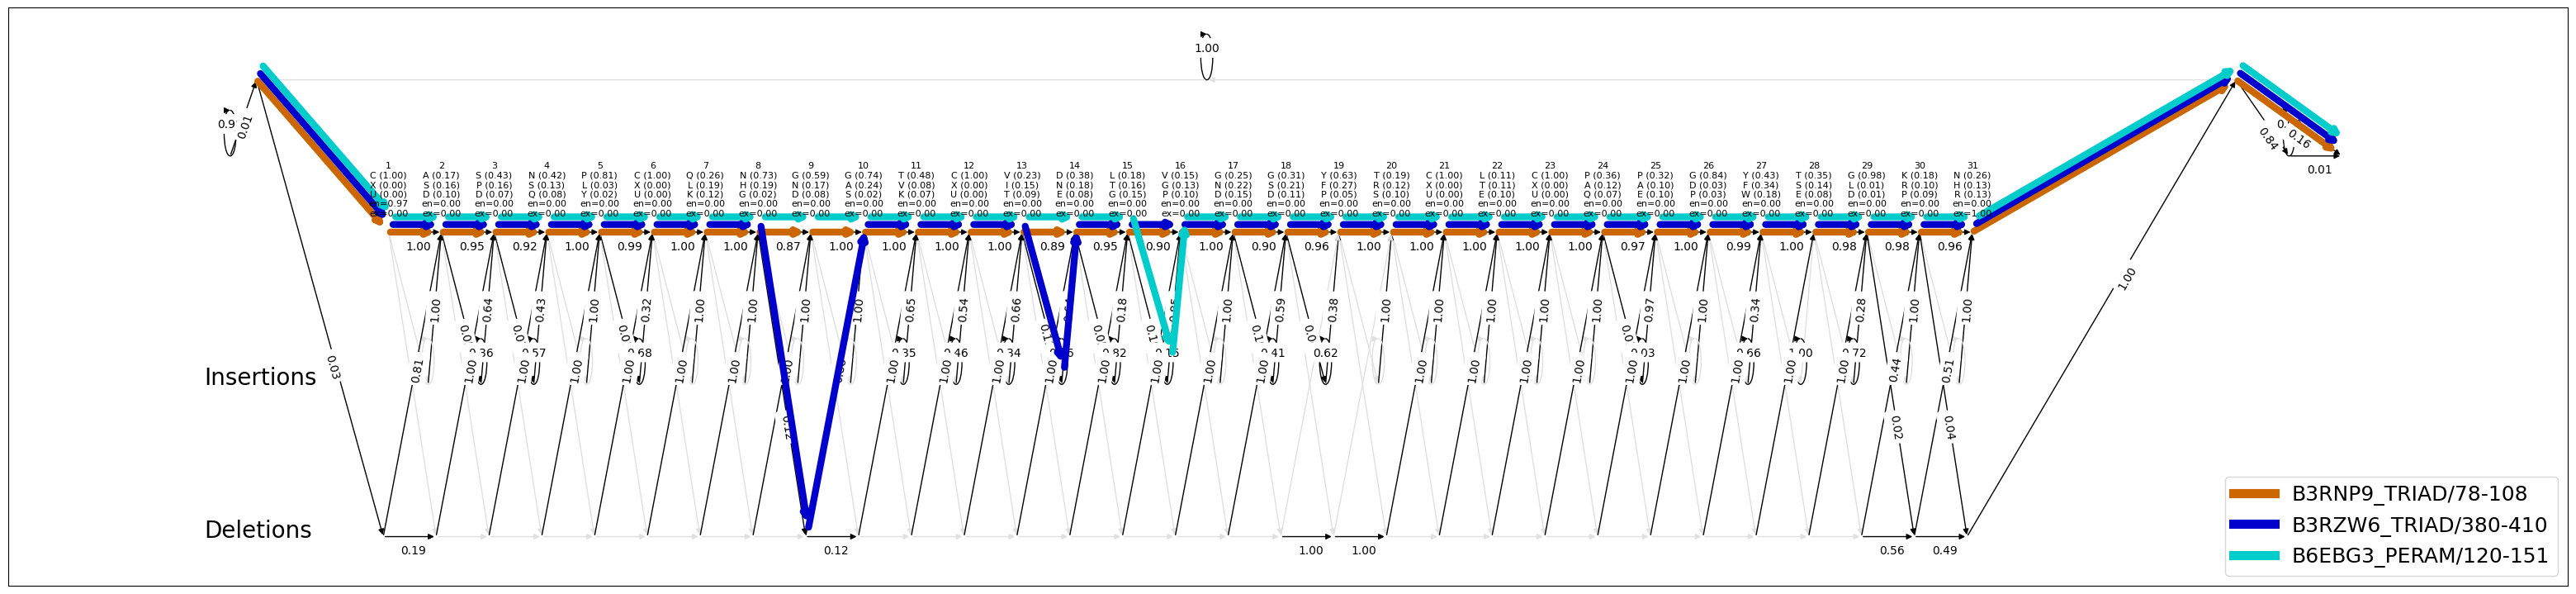

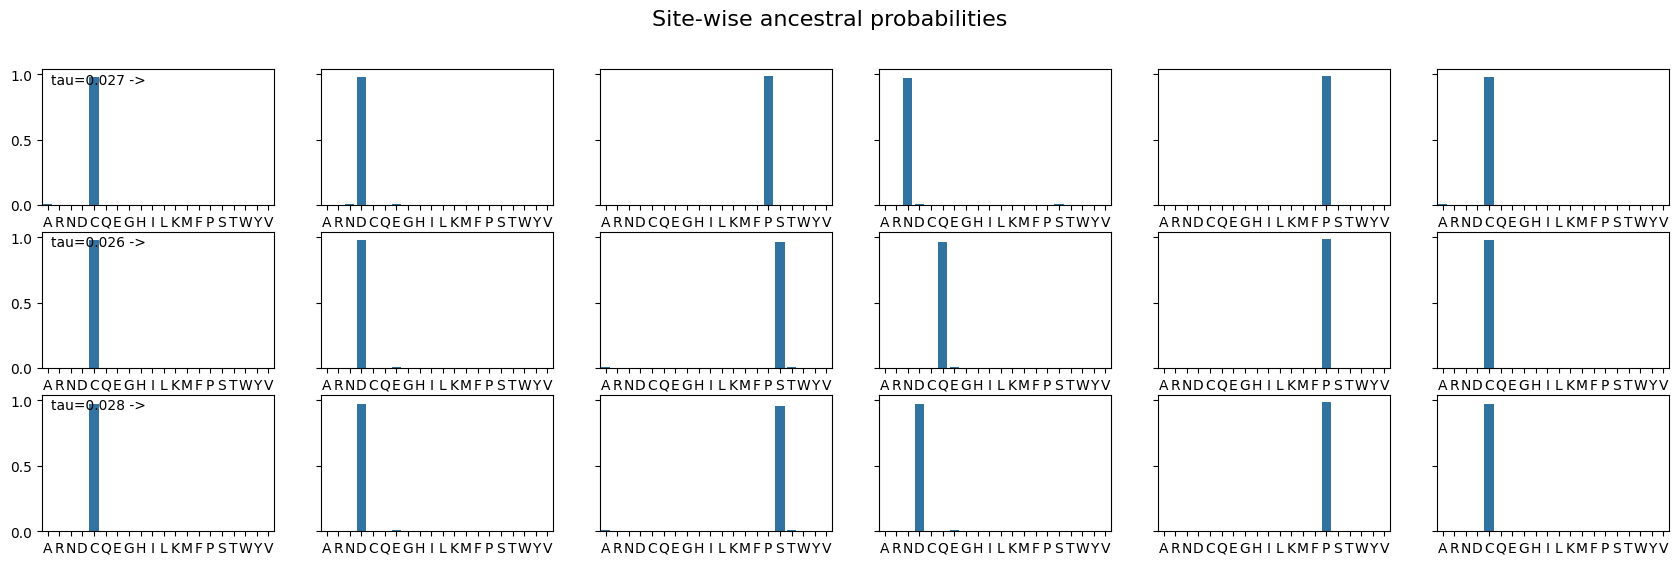

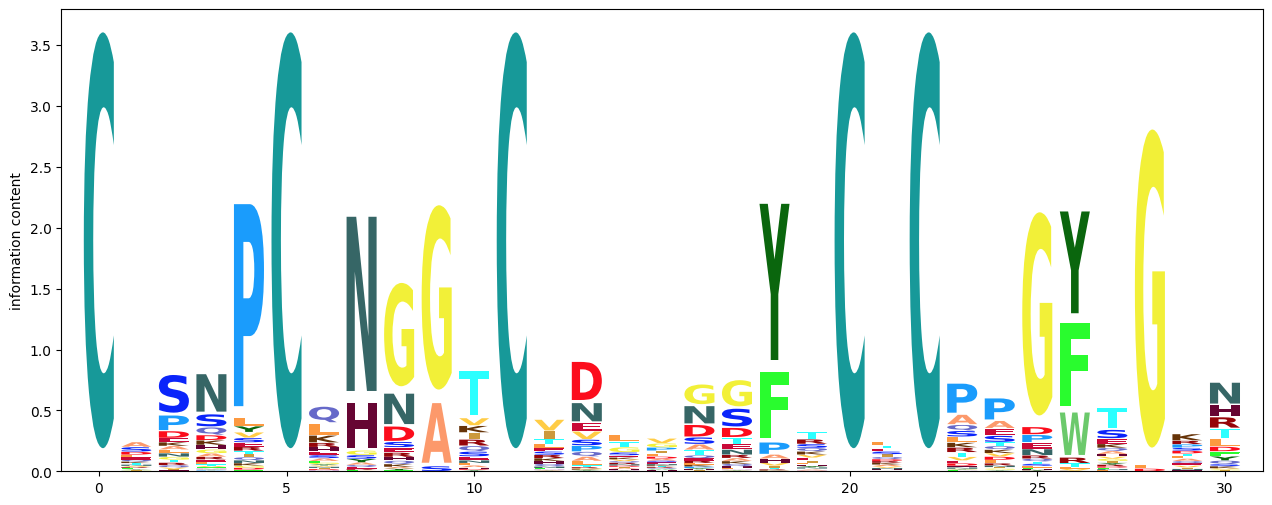

In [4]:
alignment_model = align(train_filename, "test/data/interactive.alignment.fasta") 
Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [5]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [6]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    76.8 [100.0]   [ 5182]
